# Using Monte Carlo simulation for call options pricing

### The formula use for this project will be the Risk-neutral Expectation Pricing Formula in Continuous Time.

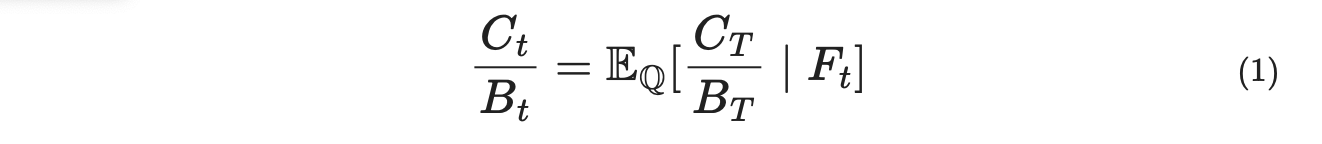

##### Disclaimer: Given that accessing data for European call options requires a subscription, this project will focus on U.S. call options, which are more easily accessible. It assumes that U.S. call options will only be exercised at expiration, with no instances of early exercise.

In [32]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf

[*********************100%%**********************]  5 of 5 completed


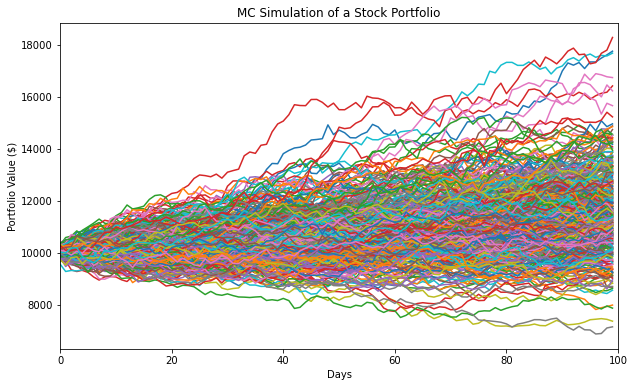

VaR_5 $768.51
CVaR_5 $1322.23


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import yfinance as yf

# Function to fetch data and calculate returns and covariance
def get_data(stocks, start, end):
    try:
        stockData = yf.download(stocks, start, end)
        stockData = stockData['Close']
        returns = stockData.pct_change().dropna()
        meanReturns = returns.mean()
        covMatrix = returns.cov()
        return meanReturns, covMatrix
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None, None

# Prepare stock data
stockList = ['META', 'AAPL', 'AMZN', 'NFLX', 'TSLA']
stocks = stockList  # No '.AX' for US stocks
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

if meanReturns is None or covMatrix is None:
    raise ValueError("Failed to retrieve stock data.")

# Generate random weights
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

# Monte Carlo Method
mc_sims = 400  # number of simulations
T = 100        # timeframe in days
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initialPortfolio = 10000

# Simulation loop
for m in range(mc_sims):
    Z = np.random.normal(size=(T, len(weights)))  # uncorrelated RVs
    L = np.linalg.cholesky(covMatrix)  # Cholesky decomposition
    dailyReturns = meanM + np.inner(L, Z)  # correlated daily returns
    portfolio_sims[:, m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolio

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC Simulation of a Stock Portfolio')
plt.xlim(0, T)
plt.show()

# VaR and CVaR functions
def mcVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas Series for returns.")

def mcCVaR(returns, alpha=5):
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas Series for returns.")

# Calculate VaR and CVaR
portResults = pd.Series(portfolio_sims[-1, :])
VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

# Print results
print('VaR_5 ${}'.format(round(VaR, 2)))
print('CVaR_5 ${}'.format(round(CVaR, 2)))


## Here is the price of TSLA call option, with all the necessary data sourced from Yahoo Finance. The current price where TSLA is trading at is $249.50

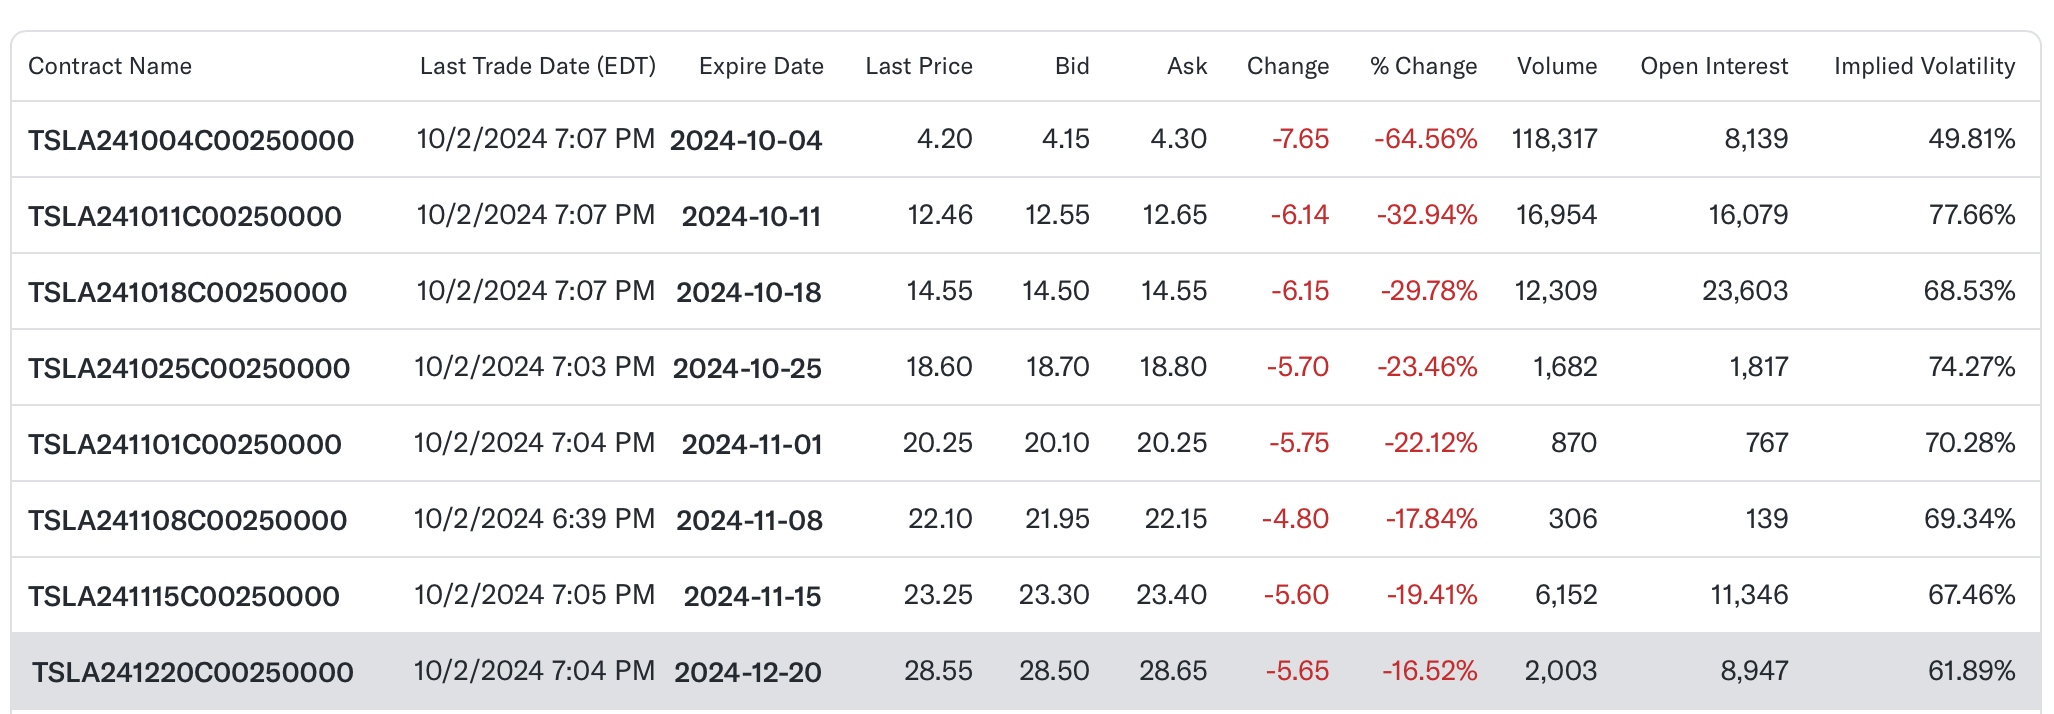

## The option price we will be looking at for this project will be $250 strike price which expires on 2024-12-20

In [34]:
#Derivative parameters
S = 249.50            #stock price
K = 250.00            #strike price
vol = 0.6189          #volatility (%)
r = 0.03              #risk-free rate (%)
N = 10                #number of time steps
M = 100000            #number of simulations

market_value = 28.55 #market price of option
T = ((datetime.date(2024,12,20)-datetime.date(2024,10,2)).days+1)/365    #time in years
print(T)

0.2191780821917808


In [42]:
# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):
    lnSt = lnS
    for j in range(N):
        lnSt = lnSt + nudt + volsdt*np.random.normal()

    ST = np.exp(lnSt)
    CT = max(0, ST - K)
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $28.96 with SE +/- 0.16


### Based on Monte Carlo Simulation, the option price for TSLA should be priced at $28.96 with a SE of +-0.16. 

### To decrease the standard error (SE), we can raise the number of simulations, denoted as \( M \) in this instance. However, doing so will necessitate additional computing resources.







# Visualising the options price on a graph

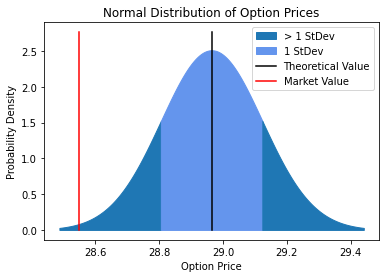

In [43]:

# Creating price ranges
x1 = np.linspace(C0 - 3 * SE, C0 - 1 * SE, 100)
x2 = np.linspace(C0 - 1 * SE, C0 + 1 * SE, 100)
x3 = np.linspace(C0 + 1 * SE, C0 + 3 * SE, 100)

# Calculating the probability density functions
s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

# Plotting the filled areas
plt.fill_between(x1, s1, color='tab:blue', label='> 1 StDev')
plt.fill_between(x2, s2, color='cornflowerblue', label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')

# Adding vertical lines for theoretical and market values
plt.plot([C0, C0], [0, max(s2) * 1.1], 'k', label='Theoretical Value')
plt.plot([market_value, market_value], [0, max(s2) * 1.1], 'r', label='Market Value')

# Labels and legend
plt.ylabel("Probability Density")
plt.xlabel("Option Price")
plt.legend()
plt.title("Normal Distribution of Option Prices")
plt.show()
